<a href="https://colab.research.google.com/github/acorbe/covid19-analytics-NL-EU/blob/master/Corona_stats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COVID-19 epidemic in the Netherlands, an open observatory for quantitative analysis

### Introduction
This Python notebook can update itself daily with the latest data from the Netherlands [1] and from all other countries in the world [2]. This page provides an example on how to perform some very basic fit to the data (i.e. the [KISS](https://en.wikipedia.org/wiki/KISS_principle) principle). The page was setup by physicists, not epidemiologist. While these data may not fully represent the extent of the epidemics, making this page publicly available can potentially enable anybody interested in trying to make sense of the data and, particularly, helping assessing the effect of past and future policies.  

#### Contacts: Alessandro Corbetta, Federico Toschi


---
#### References

[1] 2019–20 coronavirus pandemic data/Netherlands medical cases, https://en.wikipedia.org/wiki/Template:2019%E2%80%9320_coronavirus_pandemic_data/Netherlands_medical_cases

[2] European Centre for Disease Prevention and Control
An agency of the European Union, https://www.ecdc.europa.eu/en/publications-data/download-todays-data-geographic-distribution-covid-19-cases-worldwide

-----

This notebook is also accessible on GitHub at
https://github.com/acorbe/covid19-analytics-NL-EU    
<a href="https://github.com/acorbe/covid19-analytics-NL-EU "><img src="https://github.githubassets.com/images/modules/logos_page/GitHub-Logo.png" alt="github" width="70px"/></a>



### Python setup

In [0]:
# importing relevant libraries
import array as arr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

## EU Data import

The command below imports all data from ECDC european database


Link: https://www.ecdc.europa.eu/en/publications-data/download-todays-data-geographic-distribution-covid-19-cases-worldwide 

In [0]:
date_to_import = "2020-04-02"

df_orig = pd.read_excel("https://www.ecdc.europa.eu/sites/default/files/documents/COVID-19-geographic-disbtribution-worldwide-%s.xlsx" 
                        % date_to_import)

In [0]:
df_orig

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2018
0,2020-04-02,2,4,2020,26,0,Afghanistan,AF,AFG,37172386.0
1,2020-04-01,1,4,2020,25,0,Afghanistan,AF,AFG,37172386.0
2,2020-03-31,31,3,2020,27,0,Afghanistan,AF,AFG,37172386.0
3,2020-03-30,30,3,2020,8,1,Afghanistan,AF,AFG,37172386.0
4,2020-03-29,29,3,2020,15,1,Afghanistan,AF,AFG,37172386.0
...,...,...,...,...,...,...,...,...,...,...
8299,2020-03-25,25,3,2020,0,0,Zimbabwe,ZW,ZWE,14439018.0
8300,2020-03-24,24,3,2020,0,1,Zimbabwe,ZW,ZWE,14439018.0
8301,2020-03-23,23,3,2020,0,0,Zimbabwe,ZW,ZWE,14439018.0
8302,2020-03-22,22,3,2020,1,0,Zimbabwe,ZW,ZWE,14439018.0


## Initialization

The table is time-sorted and some utility columns are added


In [0]:
df_orig['DateRep'] = df_orig['dateRep']
df = df_orig.sort_values(by = ['DateRep'])

## Renaming columns for convenience
df['CountryExp'] = df['countriesAndTerritories']
df['NewConfCases'] = df['cases']
df['NewDeaths'] = df['deaths']

## Making a time column that start from 0 on 31-12-2019
df['shifted_time'] = df.groupby('CountryExp').NewConfCases.transform(lambda x : np.arange(len(x)))

## cumulative counts
df['cumsum_cases'] = df[['CountryExp', 'shifted_time', 'NewConfCases']].groupby('CountryExp').NewConfCases.cumsum()
df['cumsum_deaths'] = df[['CountryExp', 'shifted_time', 'NewConfCases','NewDeaths']].groupby('CountryExp').NewDeaths.cumsum()

##
df["DateRep"] = pd.to_datetime(df["DateRep"])

## Reduced dataset restricted to cases with at least 99 cases
df_larger_10 = df.query('cumsum_cases > 99').copy()
df_larger_10['shifted_time_new'] = df_larger_10.groupby('CountryExp').NewConfCases.transform(lambda x : np.arange(len(x)))

## Plotting data for one country (The Netherlands)

+ `first_day` counts how many days since the beginning of the dataset (31-12-2019)
+ `which_data` defines which column is plotted. 
     It can be 
     + `"cumsum_cases"`
     + `"cumsum_deaths"`



Text(0, 0.5, 'Cumulative counts')

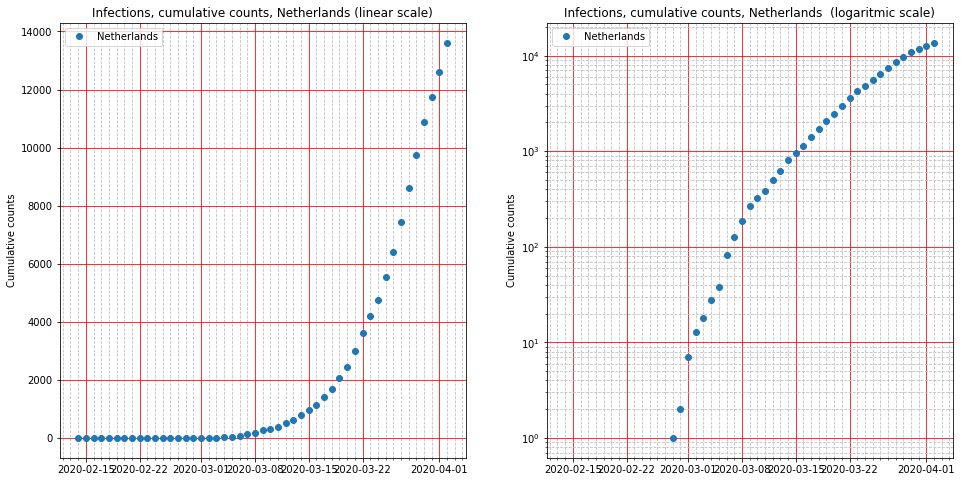

In [0]:
first_day = 45
country = 'Netherlands'
which_data = "cumsum_cases"

one_country = df.query("CountryExp == @country")[first_day:]
plt.figure(figsize=(16,8))

days = mdates.DayLocator()   # every year

## Linear scale
plt.subplot(121)
plt.plot(one_country.DateRep, one_country["cumsum_cases"],"o",label=country)
plt.title("Infections, cumulative counts, %s (linear scale)" %country)
plt.ylabel("Cumulative counts")
plt.grid(b=True, which='minor', color='0.75', linestyle='--')
plt.grid(b=True, which='major', color='red', linestyle='-')
plt.legend()
ax = plt.gca()
ax.xaxis.set_minor_locator(days)
#plt.grid()

## Log scale
plt.subplot(122)
plt.plot(one_country.DateRep, one_country["cumsum_cases"],"o",label=country)
plt.title("Infections, cumulative counts, %s  (logaritmic scale)" %country)
plt.legend()
plt.yscale('log')
ax = plt.gca()
ax.xaxis.set_minor_locator(days)
plt.grid(b=True, which='minor', color='0.75', linestyle='--')
plt.grid(b=True, which='major', color='red', linestyle='-')
plt.ylabel("Cumulative counts")


## Show data from table


In [0]:
one_country.head()

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2018,DateRep,CountryExp,NewConfCases,NewDeaths,shifted_time,cumsum_cases,cumsum_deaths
5405,2020-02-14,14,2,2020,0,0,Netherlands,NL,NLD,17231017.0,2020-02-14,Netherlands,0,0,45,0,0
5404,2020-02-15,15,2,2020,0,0,Netherlands,NL,NLD,17231017.0,2020-02-15,Netherlands,0,0,46,0,0
5403,2020-02-16,16,2,2020,0,0,Netherlands,NL,NLD,17231017.0,2020-02-16,Netherlands,0,0,47,0,0
5402,2020-02-17,17,2,2020,0,0,Netherlands,NL,NLD,17231017.0,2020-02-17,Netherlands,0,0,48,0,0
5401,2020-02-18,18,2,2020,0,0,Netherlands,NL,NLD,17231017.0,2020-02-18,Netherlands,0,0,49,0,0


## Comparing multiple countries 
In the following we plot the cumulative sum of cases for
*   The Netherlands
*   Italy
*   Belgium

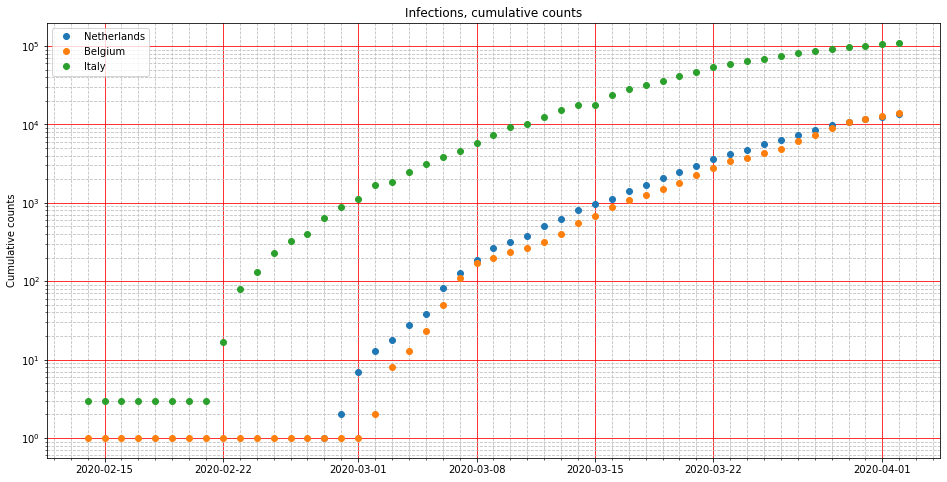

In [0]:
first_day = 45
countries = ['Netherlands','Belgium','Italy']
which_data = "cumsum_cases"
plt.figure(figsize=(16,8))

## plotting data from each country
for country in countries:
  one_country = df.query("CountryExp == @country")[first_day:]
  plt.plot(one_country.DateRep, one_country["cumsum_cases"],"o",label=country)

plt.ylabel("Cumulative counts")
plt.legend()
plt.grid()
plt.title("Infections, cumulative counts")
plt.yscale('log')

plt.grid(b=True, which='minor', color='0.75', linestyle='--')
plt.grid(b=True, which='major', color='red', linestyle='-')
days = mdates.DayLocator()   
ax = plt.gca()
ax.xaxis.set_minor_locator(days)


## Data fitting with a simple sigmoid function (logistic model)


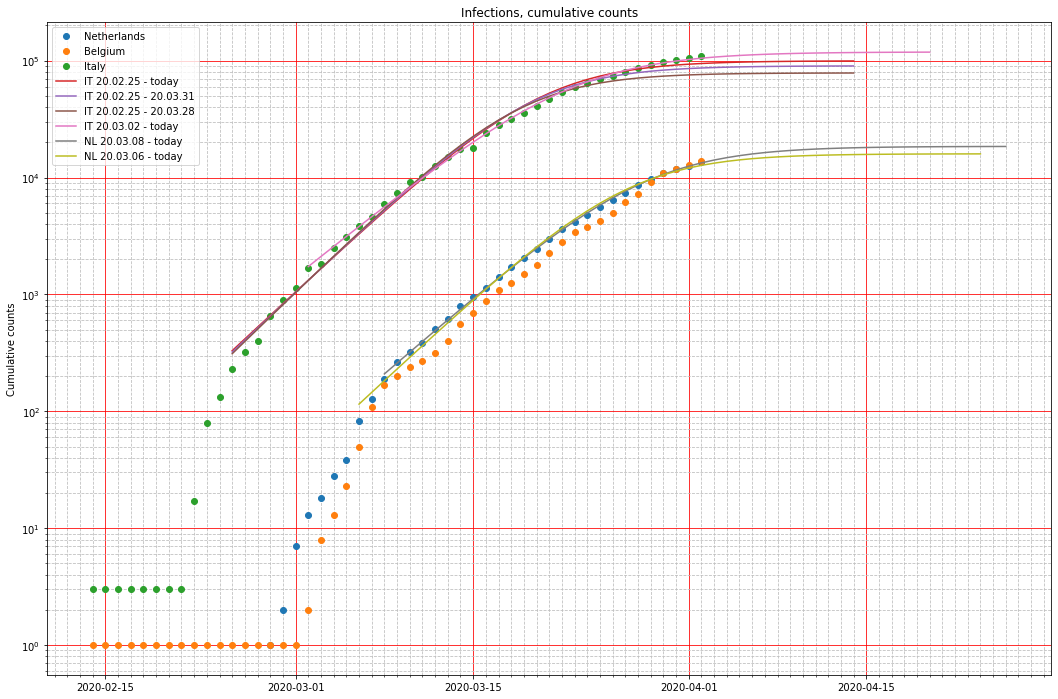

In [0]:
first_day = 45
fit_first_day_it = 56
fit_first_day_nl = 68

countries = ['Netherlands','Belgium','Italy']
which_data = "cumsum_cases"

plt.figure(figsize=(18,12))

for country in countries:
  one_country = df.query("CountryExp == @country")[first_day:]
  plt.plot(one_country.DateRep, one_country["cumsum_cases"],"o",label=country)

plt.ylabel("Cumulative counts")
plt.legend()
plt.grid()
plt.title("Infections, cumulative counts")
plt.yscale('log')

def flogistic(xx,p,k,r):  
  return p*k / (p + (p-k)*np.exp(-r*xx))

def logflogistic(xx,p,k,r):  
  return np.log(p*k / (p + (p-k)*np.exp(-r*xx)))

def fit_in_interval(one_country_ext,label='log-fit'):
  one_country = one_country_ext
  import scipy.optimize as opt

  ydata =  one_country.cumsum_cases
  integers_ = np.arange(len(one_country.cumsum_cases))

  popt_log, pcov_log = opt.curve_fit( flogistic, integers_ , ydata )

  log_popt_log, log_pcov_log = opt.curve_fit( logflogistic
                                            , integers_ 
                                            , np.log(ydata)
                                            , p0=popt_log)
  days_with_future_int = np.arange(50)  
  days_with_future = pd.Series([pd.Timedelta(days=x) for x in np.arange(50) ])
  
  plt.plot(days_with_future + one_country.DateRep.iloc[0] 
          , np.exp(logflogistic(days_with_future_int, *log_popt_log)), label=label )

it_time_columns = df.query("CountryExp == 'Italy'")[fit_first_day_it:].DateRep.dt.strftime("%y.%m.%d")
fit_in_interval(df.query("CountryExp == 'Italy'")[fit_first_day_it:],label ='IT %s - today' % it_time_columns.iloc[0]) #,0,-1)
fit_in_interval(df.query("CountryExp == 'Italy'")[fit_first_day_it:][:-3],label='IT %s - %s' % (it_time_columns.iloc[0],it_time_columns.iloc[-3]) )
fit_in_interval(df.query("CountryExp == 'Italy'")[fit_first_day_it:][:-6],label='IT %s - %s' % (it_time_columns.iloc[0],it_time_columns.iloc[-6]))
fit_in_interval(df.query("CountryExp == 'Italy'")[fit_first_day_it:][6:],label='IT %s - today' % it_time_columns.iloc[6])


nl_time_columns = df.query("CountryExp == 'Netherlands'").DateRep.dt.strftime("%y.%m.%d")
fit_in_interval(df.query("CountryExp == 'Netherlands'")[fit_first_day_nl:],label='NL %s - today' % nl_time_columns.iloc[fit_first_day_nl])
fit_in_interval(df.query("CountryExp == 'Netherlands'")[fit_first_day_nl-2:],label='NL %s - today' % nl_time_columns.iloc[fit_first_day_nl-2])
#fit_in_interval(df.query("CountryExp == 'Netherlands'")[fit_first_day_nl-4:],label='NL %s - today' % nl_time_columns.iloc[fit_first_day_nl-4])

plt.grid()
plt.grid(b=True, which='minor')#, color='r', linestyle='--')
plt.legend()
plt.grid(b=True, which='minor', color='0.75', linestyle='--')
plt.grid(b=True, which='major', color='red', linestyle='-')
days = mdates.DayLocator()   
ax = plt.gca()
ax.xaxis.set_minor_locator(days)

## Aligning time for different countries (e.g. to check the delay of the epidemic between different countries)

---



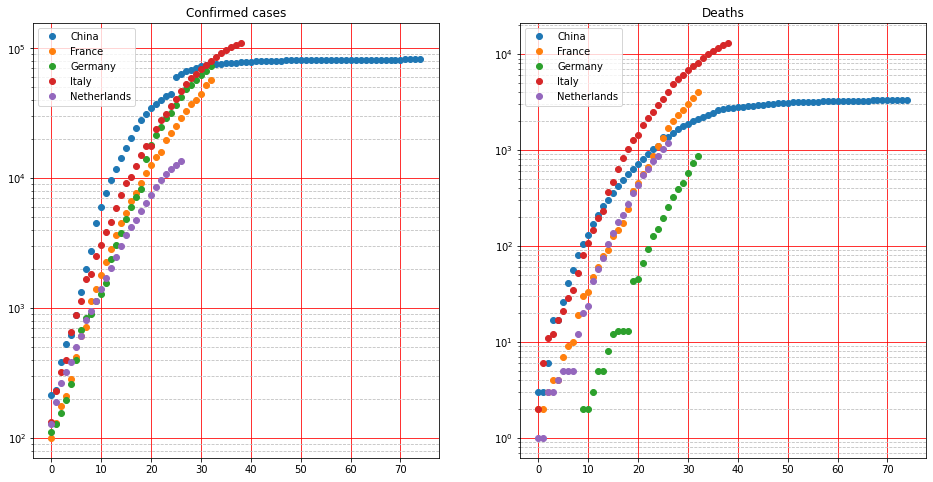

In [0]:
countries = ["Italy", "China", "Netherlands","Germany","France"]

plt.figure(figsize = (16,8))
plt.subplot(121)

#df.query('CountryExp in @countries').groupby('CountryExp').apply(lambda x : plt.plot(x.shifted_time,x.cumsum_cases)) #.cumsum_cases.plot()

for k,v in df_larger_10.query('CountryExp in @countries').groupby('CountryExp'):
  plt.plot(v.shifted_time_new,v.cumsum_cases,'o',label=k)
plt.title('Confirmed cases')
plt.yscale('log')
plt.grid(b=True, which='minor', color='0.75', linestyle='--')
plt.grid(b=True, which='major', color='red', linestyle='-')

plt.legend()

plt.subplot(122)
for k,v in df_larger_10.query('CountryExp in @countries').groupby('CountryExp'):
  plt.plot(v.shifted_time_new,v.cumsum_deaths,'o',label=k)

plt.title('Deaths')
plt.yscale('log')

ax = plt.gca()
#ax.xaxis.set_minor_locator(1)
plt.grid(b=True, which='minor', color='0.75', linestyle='--')
plt.grid(b=True, which='major', color='red', linestyle='-')

plt.legend()

## Aligning time for different countries, normalizing the counts vs. the population


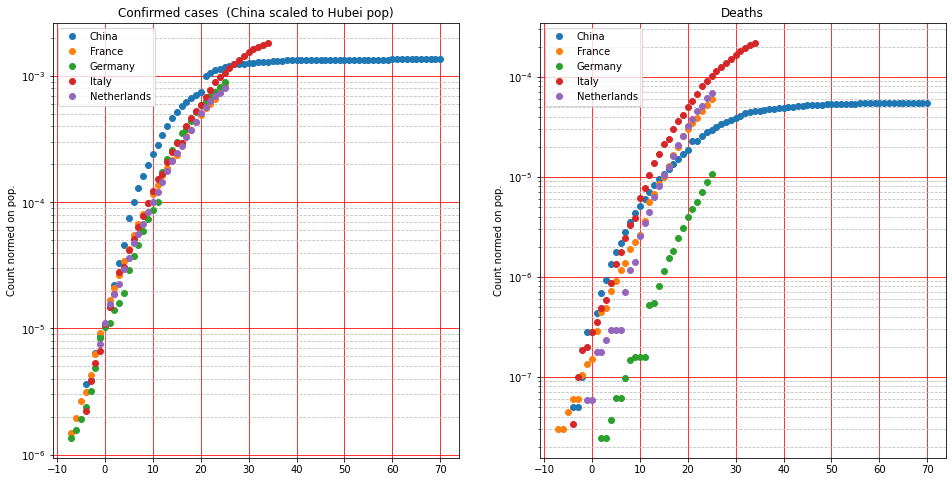

In [0]:
countries = ["Italy", "China", "Netherlands","Germany", "France"]
est_pop = [60e6,  60e6 ,17e6, 82e6,67e6 ]

pop_df = pd.DataFrame({"CountryExp": countries, "population" : est_pop})

df_loc = pd.merge(df_larger_10, pop_df, on='CountryExp')

df_loc['rel_cumsum_cases'] = df_loc.cumsum_cases/df_loc.population
df_loc['rel_cumsum_cases_st_1em5'] = df_loc['rel_cumsum_cases'] < 1e-5
df_loc['conf_rel_gt1em5'] =  df_loc.groupby('CountryExp').rel_cumsum_cases_st_1em5.transform('sum')


plt.figure(figsize = (16,8))
plt.subplot(121)

#df.query('CountryExp in @countries').groupby('CountryExp').apply(lambda x : plt.plot(x.shifted_time,x.cumsum_cases)) #.cumsum_cases.plot()

for k,v in df_loc.query('CountryExp in @countries').groupby('CountryExp'):
  plt.plot(v.shifted_time_new - v.conf_rel_gt1em5 ,v.cumsum_cases/v.population,'o',label=k)
plt.title('Confirmed cases  (China scaled to Hubei pop)')

plt.grid(b=True, which='minor', color='0.75', linestyle='--')
plt.grid(b=True, which='major', color='red', linestyle='-')

plt.ylabel('Count normed on pop.')
plt.yscale('log')
plt.legend()

plt.subplot(122)
for k,v in df_loc.query('CountryExp in @countries').groupby('CountryExp'):
  plt.plot(v.shifted_time_new - v.conf_rel_gt1em5,v.cumsum_deaths/v.population,'o',label=k)

plt.grid(b=True, which='minor', color='0.75', linestyle='--')
plt.grid(b=True, which='major', color='red', linestyle='-')

plt.title('Deaths')
plt.ylabel('Count normed on pop.')
plt.yscale('log')
plt.legend()

# Netherdelands data - from wikipedia

In [0]:
## importing and cleaning data from citations. 
## relevant columns are casted to numbers (float)

my_html_table = "https://en.wikipedia.org/wiki/Template:2019%E2%80%9320_coronavirus_pandemic_data/Netherlands_medical_cases"

import pandas as pd
A = pd.read_html(my_html_table)

NL_situation = A[0][:-2]


def split_if_necessary(x):
  try:
    value = x.split('[')[0]
  except:
    value = float(x)

  return value

NL_situation_cleaned = NL_situation.applymap(split_if_necessary)
numeric_columns = [ x for  x in NL_situation_cleaned.columns 
                   if x[0] not in ["Date[a]", "Source(s)"] and x[1] not in ["Diff."] ]

NL_situation_cleaned[numeric_columns] = NL_situation_cleaned[numeric_columns].astype(float)
# converting dates
NL_situation_cleaned[("Date[a]","Date[a]")] = pd.to_datetime(NL_situation_cleaned["Date[a]"]["Date[a]"])

NL_situation_cleaned = NL_situation_cleaned.set_index(NL_situation_cleaned[("Date[a]","Date[a]")])
NL_situation_cleaned.index.rename("Date",inplace=True)


## Data by province

In [0]:
NL_situation_cleaned["Province"]

,NB,NH,ZH,DR,UT,GD,FL,OV,LB,ZL,FR,GR,Unk.
Date,,,,,,,,,,,,,
2020-02-27,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-28,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-29,2.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-01,1.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-02,4.0,1.0,1.0,1.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-03,4.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-04,5.0,4.0,4.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-05,7.0,2.0,5.0,1.0,20.0,1.0,1.0,1.0,2.0,NaN,NaN,NaN,4.0
2020-03-06,10.0,1.0,10.0,NaN,10.0,8.0,1.0,NaN,7.0,NaN,NaN,NaN,-1.0


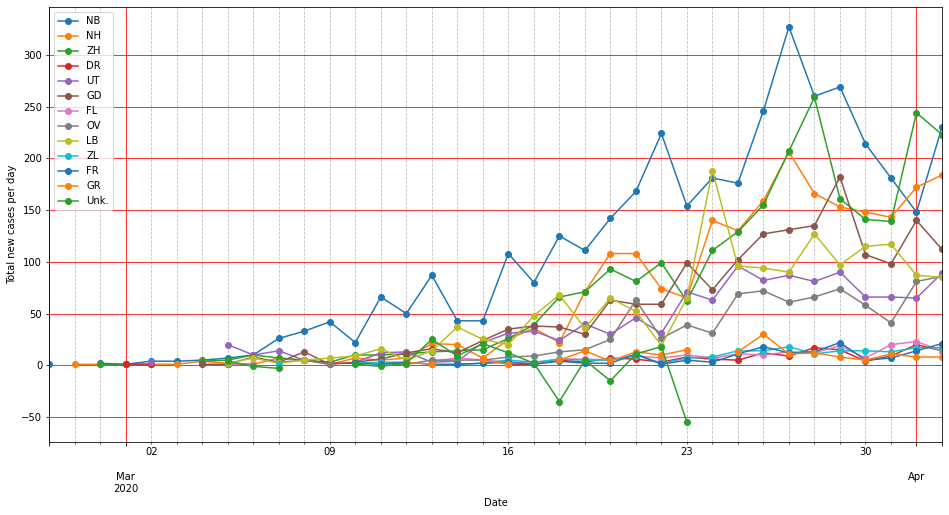

In [0]:
plt.figure(figsize=(16,8))
ax = plt.gca()
NL_situation_cleaned['Province'].plot(marker='o',ax = ax)
plt.ylabel("Total new cases per day")

plt.grid(b=True, which='minor', color='0.75', linestyle='--')
plt.grid(b=True, which='major', color='red', linestyle='-')

days = mdates.DayLocator()   
ax = plt.gca()
ax.xaxis.set_minor_locator(days)

(737482.0, 737527.0)

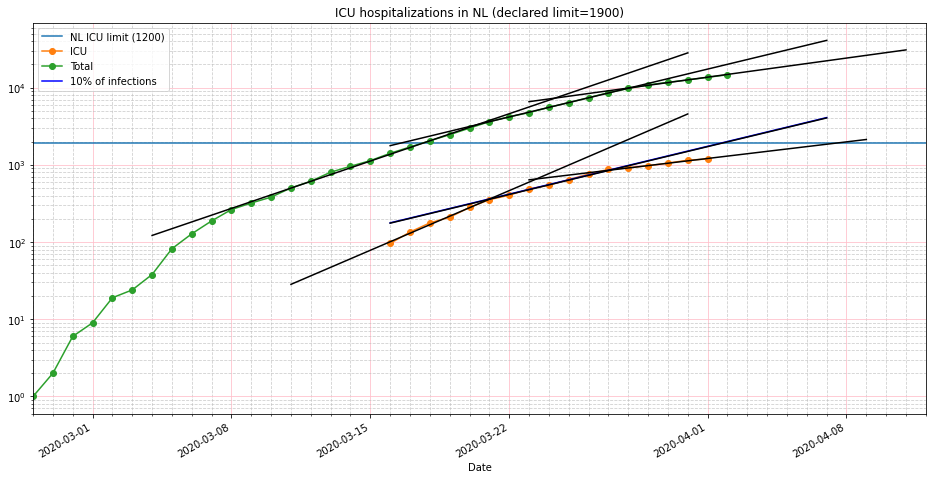

In [0]:
## ICU Patients
NL_ICU_LIMIT = 1900

# Data on ICU beds in NL: https://www.stichting-nice.nl/


plt.figure(figsize=(16,8))
ax = plt.gca()

total_cases = NL_situation_cleaned['Cases[b]']['Total']
icu_cases = NL_situation_cleaned['Hospitalizations']['ICU']
timespan = [NL_situation_cleaned.index[0]
            , NL_situation_cleaned.index[-1]]


extended_timespan = [NL_situation_cleaned.index[0]
            , NL_situation_cleaned.index[-1] + pd.Timedelta(days = 10)]


ax.plot(extended_timespan,[NL_ICU_LIMIT,NL_ICU_LIMIT]
         ,label="NL ICU limit (1200)")

icu_cases.plot(marker='o',ax = ax)
total_cases.plot(marker='o',ax = ax)

def exp_fit_portion(ydata_all
                    ,extend_fit_days = 10
                    ,extend_fit_days_before = 5
                    ,rescale = 1.
                    ,plot_kw = {}):
  """Fits data, input like: total_cases["09-Mar-2020":"21-Mar-2020"]
  """  
  ydata = ydata_all.values
  xdata = np.arange(len(ydata))
  xdata_extended = np.arange(-extend_fit_days_before, len(ydata) + extend_fit_days)
  xdata_idx = ydata_all.index
  logy = np.log(ydata)
  ret = np.polyfit(xdata,logy,1)  
  fit_y = np.exp(np.polyval(ret,xdata_extended))
  
  xdata_idx_extended = [xdata_idx[0] + pd.Timedelta(days = x - extend_fit_days_before) 
                          for x in range(len(xdata_idx) + extend_fit_days + extend_fit_days_before)]
  ax.plot(xdata_idx_extended,rescale * fit_y,**plot_kw)

exp_fit_portion(total_cases["09-Mar-2020":"21-Mar-2020"],plot_kw={"color" : "k", "linewidth" : 1.5})
exp_fit_portion(total_cases["21-Mar-2020":"28-Mar-2020"],plot_kw={"color" : "k", "linewidth" : 1.5})
exp_fit_portion(total_cases["28-Mar-2020":"1-Apr-2020"],plot_kw={"color" : "k", "linewidth" : 1.5})

exp_fit_portion(total_cases["21-Mar-2020":"28-Mar-2020"]
                ,rescale=0.10
                ,plot_kw={"color" : "b", "linewidth" : 1.5, "label" : "10% of infections"})

exp_fit_portion(icu_cases["16-Mar-2020":"21-Mar-2020"],plot_kw={"color" : "k", "linewidth" : 1.5})
exp_fit_portion(icu_cases["21-Mar-2020":"28-Mar-2020"],plot_kw={"color" : "k", "linewidth" : 1.5})
exp_fit_portion(icu_cases["28-Mar-2020":"30-Mar-2020"],plot_kw={"color" : "k", "linewidth" : 1.5})

plt.legend()
plt.yscale('log')
plt.title('ICU hospitalizations in NL (declared limit=%d)'% NL_ICU_LIMIT)

plt.grid(b=True, which='minor', color='0.75', alpha=0.75, linestyle='--')
plt.grid(b=True, which='major', color='pink', alpha=1,linestyle='-')

days = mdates.DayLocator()   
ax = plt.gca()
ax.xaxis.set_minor_locator(days)

plt.xlim([timespan[0],timespan[1] + pd.Timedelta(days=10)])


In [0]:
total_cases["09-Mar-2020":"21-Mar-2020"]

Date
2020-03-09     321.0
2020-03-10     382.0
2020-03-11     503.0
2020-03-12     614.0
2020-03-13     804.0
2020-03-14     959.0
2020-03-15    1135.0
2020-03-16    1413.0
2020-03-17    1705.0
2020-03-18    2051.0
2020-03-19    2460.0
2020-03-20    2994.0
2020-03-21    3631.0
Name: Total, dtype: float64